Participate in the design of an autonomous car
----------------

####  Now we consider only the Mobilenet segnet model and compare it with two loss function: dice loss and balanced cross entropy.

In [ ]:
import pandas as pd
import numpy as np
import os, glob
import random
from time import time
import tqdm
from collections import namedtuple

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from imgaug import augmenters as iaa

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
train_input_dir = '/content/drive/MyDrive/P08/train/images'
train_mask_dir = '/content/drive/MyDrive/P08/train/masks30'
train_target_dir = '/content/drive/MyDrive/P08/train/masks'
val_input_dir = '/content/drive/MyDrive/P08/val/images'
val_mask_dir = '/content/drive/MyDrive/P08/val/masks30'
val_target_dir = '/content/drive/MyDrive/P08/val/masks'
test_input_dir = '/content/drive/MyDrive/P08/test/images'
test_mask_dir = '/content/drive/MyDrive/P08/test/masks30'
test_target_dir = '/content/drive/MyDrive/P08/test/masks'
model_path = '/content/drive/MyDrive/P08/models'
checkpoint_path='/content/drive/MyDrive/P08/checkpoints'

In [ ]:
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_mask_path = sorted(glob.glob(train_mask_dir +'/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of original masks: ', len(train_mask_path),
      ' - Number of masks in 8 categories: ', len(train_target_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_mask_path = sorted(glob.glob(val_mask_dir +'/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))
print('VAL -- Number of images: ', len(val_input_path), 
      ' - Number of original masks: ', len(val_mask_path),
      ' - Number of masks in 8 categories: ', len(val_target_path))
print(val_input_path[0] + '\n')

test_input_path = sorted(glob.glob(test_input_dir + '/*.png'))
test_mask_path = sorted(glob.glob(test_mask_dir +'/*.png'))
test_target_path = sorted(glob.glob(test_target_dir +'/*.png'))
print('TEST -- Number of images: ', len(test_input_path), 
      ' - Number of original masks: ', len(test_mask_path),
      ' - Number of masks in 8 categories: ', len(test_target_path))
print(test_input_path[0])

TRAIN -- Number of images:  2400  - Number of original masks:  2400  - Number of masks in 8 categories:  2400
/content/drive/MyDrive/P08/train/images/aachen_000000_000019.png

VAL -- Number of images:  575  - Number of original masks:  575  - Number of masks in 8 categories:  575
/content/drive/MyDrive/P08/val/images/stuttgart_000124_000019.png

TEST -- Number of images:  500  - Number of original masks:  500  - Number of masks in 8 categories:  500
/content/drive/MyDrive/P08/test/images/frankfurt_000000_000294.png


In [ ]:
# Function to resize image
def resize_dataset(pred, img_width, img_height):
    img = pred
    # Use interpolation inter_nearest to use integer with cv2
    resized_img = cv2.resize(img, dsize=(img_width, img_height),
                             interpolation=cv2.INTER_NEAREST)
    return resized_img

# Function to plot original images and masks VS. predicted masks
def plot_image_mask_prediction(test_input_path, test_target_path, 
                               img_height, img_width, random=True, n=5):
    
    if random:
        # Generate random images/masks of n-number
        ids = np.random.choice(np.arange(len(test_input_path)), size=n)
        print(ids)
    
    else:
        ids = [498, 175]
    
    # Plot
    for i in ids:
        image = img_to_array(load_img(f'{test_input_path[i]}'))/255.
        mask = img_to_array(load_img(f'{test_target_path[i]}',
                                     color_mode = "grayscale"))
        mask = np.squeeze(mask)
        pred = model.predict_segmentation(inp=test_input_path[i])
        pred= resize_dataset(pred, img_width, img_height)
        
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(1, 3, 1)
        ax.set_title('Image')
        ax.imshow(image)
        
        ax1 = fig.add_subplot(1, 3, 2)
        ax1.set_title('True mask')
        ax1.imshow(mask, cmap='nipy_spectral_r' )
        
        ax2 = fig.add_subplot(1, 3, 3)
        ax2.set_title('predicted_Mask')
        ax2.imshow(pred, cmap='nipy_spectral_r')

In [ ]:
from IPython.display import clear_output
!pip install --upgrade git+https://github.com/santra11/image-segmentation-keras.git
clear_output()

from keras_segmentation.models.segnet import mobilenet_segnet

#### Hyperparameters for the model

In [ ]:
img_height, img_width = 256, 512
img_size = (img_height, img_width)
batch_size = 20
n_classes = 8
samples = len(train_input_path)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mean_IoU = tf.keras.metrics.MeanIoU(num_classes=8, name='mean_IoU')
epochs = 10

#### Loss function Balanced Cross-entropy

In [ ]:
beta=0.5

def balanced_cross_entropy(beta):
  def loss(y_true, y_pred):
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = (1 - beta) * tf.cast(1 - y_true, tf.float32)
    
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
    return tf.reduce_mean(o)

  return loss

#### Dice Loss

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)

    numerator = 2 * tf.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.reduce_sum(y_true + y_pred) + smooth

    return 1 - numerator / denominator

#### Create the dataframe to compare the models

In [ ]:
df_result = pd.DataFrame(
    columns= ['model',
              'epoch',
              'training_time',
              'eval_time',
              'freq_weighted_IoU',
              'mean_IoU',
              'void_IoU',
              'flat_IoU',
              'construction_IoU',
              'object_IoU',
              'nature_IoU',
              'sky_IoU',
              'human_IoU',
              'vehicule_IoU'])

In [ ]:
def model_result_to_dataframe(model_name, epochs, training_time, eval_time, 
                              df_result, model_result, do_augment=False):

    if do_augment==True:
        model_name = (f'augmented_{model_name}')

    df_result =df_result.append(
        {'model':model_name,
         'epoch': epochs,
         'training_time':training_time,
         'eval_time':eval_time,
         'freq_weighted_IoU':model_result["frequency_weighted_IU"],
         'mean_IoU':model_result["mean_IU"],
         'void_IoU':model_result["class_wise_IU"][0],
         'flat_IoU':model_result["class_wise_IU"][1],
         'construction_IoU':model_result["class_wise_IU"][2],
         'object_IoU':model_result["class_wise_IU"][3],
         'nature_IoU':model_result["class_wise_IU"][4],
         'sky_IoU':model_result["class_wise_IU"][5],
         'human_IoU':model_result["class_wise_IU"][6],
         'vehicule_IoU':model_result["class_wise_IU"][7]},
         ignore_index=True)
    
    return df_result

####  Mobilenet Segnet model with balanced cross entropy.

In [ ]:
model_name= 'mobilenet_segnet_bent'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

In [ ]:
# Check model summary
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 512, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 258, 514, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 128, 256, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 256, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 128, 256, 32)      0         
                                                                 
 conv_pad_1 (ZeroPadding2D)  (None, 130, 258, 32)      0         
                                                           

Training for mobilenet_segnet_bent
Verifying training dataset


100%|██████████| 2400/2400 [15:53<00:00,  2.52it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 575/575 [02:58<00:00,  3.22it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 950s 2s/step - loss: 0.3293 - score_IoU: 0.5544 - accuracy: 0.8961 - val_loss: 0.3287 - val_score_IoU: 0.6535 - val_accuracy: 0.9053
Epoch 2/10
512/512 [==============================] - 937s 2s/step - loss: 0.3278 - score_IoU: 0.6935 - accuracy: 0.9197 - val_loss: 0.3290 - val_score_IoU: 0.7757 - val_accuracy: 0.9005
Epoch 3/10
512/512 [==============================] - 941s 2s/step - loss: 0.3274 - score_IoU: 0.7853 - accuracy: 0.9269 - val_loss: 0.3283 - val_score_IoU: 0.8006 - val_accuracy: 0.9112
Epoch 4/10
512/512 [==============================] - 1136s 2s/step - loss: 0.3271 - score_IoU: 0.8185 - accuracy: 0.9315 - val_loss: 0.3285 - val_score_IoU: 0.8277 - val_accuracy: 0.9082
Epoch 5/10
512/512 [==============================] - 939s 2s/step - loss: 0.3268 - score_IoU: 0.8482 - accuracy: 0.9364 - val_loss: 0.3292 - val_score_IoU: 0.8365 - val_accuracy: 0.8979
Epoch 6/10
512/512 [=========================

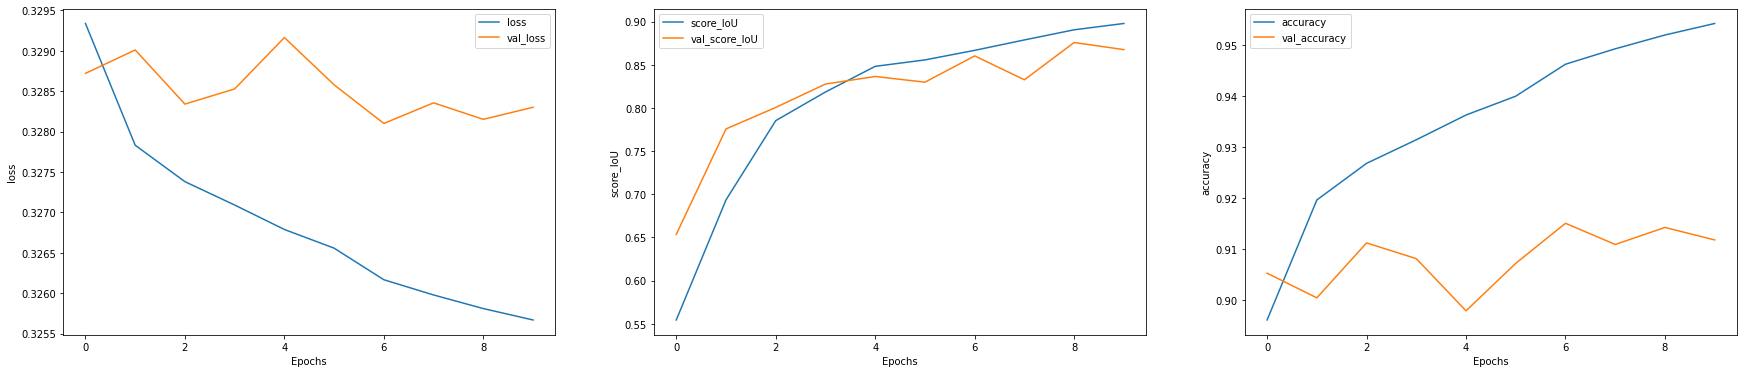

Training time : 10822.000623226166


In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=balanced_cross_entropy(beta),
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

In [ ]:
# Evaluate the model
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [03:25,  2.43it/s]

Evaluation time : 206.04665517807007


[247 196]


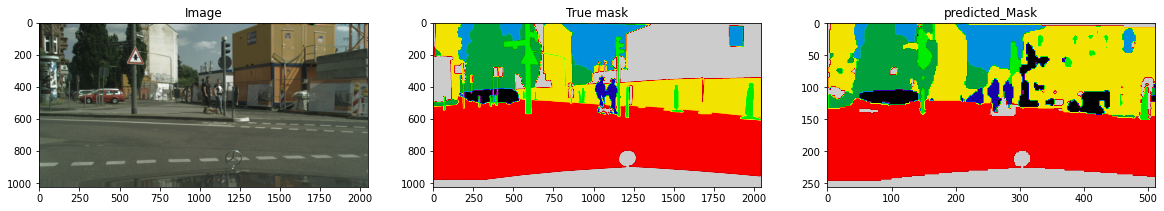

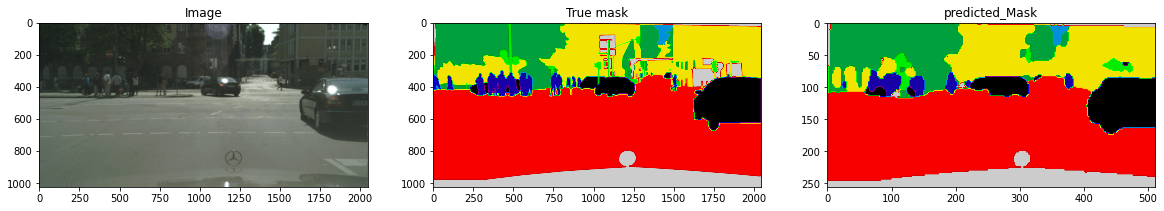

In [ ]:
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=2)

In [ ]:
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=False)
# Display result
df_result

,model,epoch,training_time,eval_time,freq_weighted_IoU,mean_IoU,void_IoU,flat_IoU,construction_IoU,object_IoU,nature_IoU,sky_IoU,human_IoU,vehicule_IoU
0,mobilenet_segnet_bent,10,10822.000623,206.046655,0.818017,0.700274,0.669688,0.920698,0.792341,0.240373,0.818038,0.839866,0.518774,0.80241


#### With dice loss

In [ ]:
model_name= 'mobilenet_segnet_dice'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

In [ ]:
# Check model summary
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 512, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 258, 514, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 128, 256, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 256, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 128, 256, 32)      0         
                                                                 
 conv_pad_1 (ZeroPadding2D)  (None, 130, 258, 32)      0         
                                                          

Training for mobilenet_segnet_dice
Verifying training dataset


100%|██████████| 2400/2400 [03:10<00:00, 12.61it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 575/575 [00:45<00:00, 12.57it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 948s 2s/step - loss: 0.7302 - score_IoU: 0.6052 - accuracy: 0.8914 - val_loss: 0.7300 - val_score_IoU: 0.6653 - val_accuracy: 0.8935
Epoch 2/10
512/512 [==============================] - 944s 2s/step - loss: 0.7283 - score_IoU: 0.7427 - accuracy: 0.9123 - val_loss: 0.7291 - val_score_IoU: 0.7942 - val_accuracy: 0.9030
Epoch 3/10
512/512 [==============================] - 943s 2s/step - loss: 0.7272 - score_IoU: 0.8036 - accuracy: 0.9243 - val_loss: 0.7290 - val_score_IoU: 0.8325 - val_accuracy: 0.9040
Epoch 4/10
512/512 [==============================] - 949s 2s/step - loss: 0.7267 - score_IoU: 0.8597 - accuracy: 0.9298 - val_loss: 0.7285 - val_score_IoU: 0.8555 - val_accuracy: 0.9097
Epoch 5/10
512/512 [==============================] - 945s 2s/step - loss: 0.7263 - score_IoU: 0.8770 - accuracy: 0.9344 - val_loss: 0.7290 - val_score_IoU: 0.8533 - val_accuracy: 0.9034
Epoch 6/10
512/512 [==========================

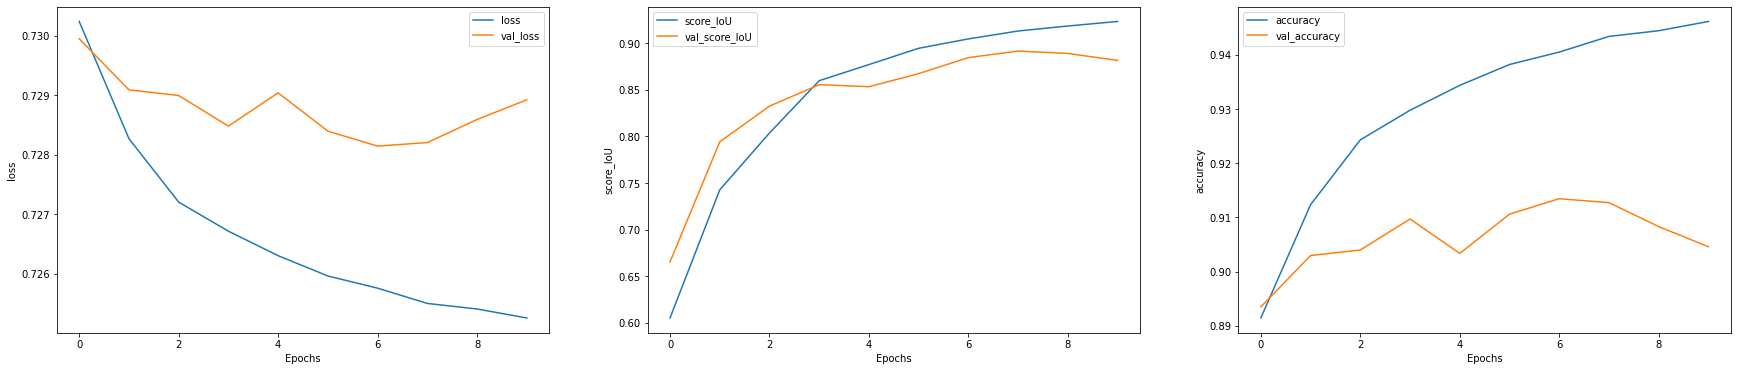

Training time : 9745.670640468597


In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=dice_loss,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

In [ ]:
# Evaluate the model
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [01:20,  6.23it/s]

Evaluation time : 80.60515069961548


#### Plot the prediction as image and mask

[176  61]


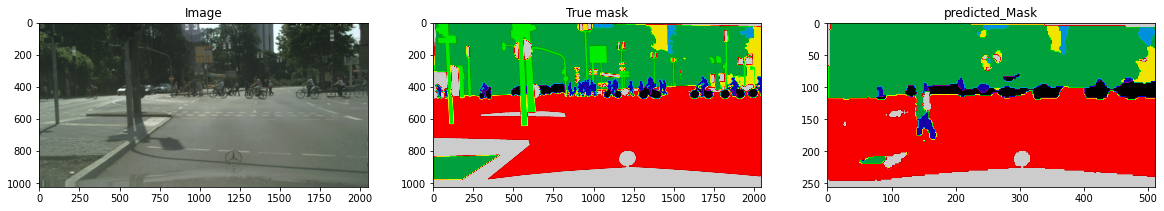

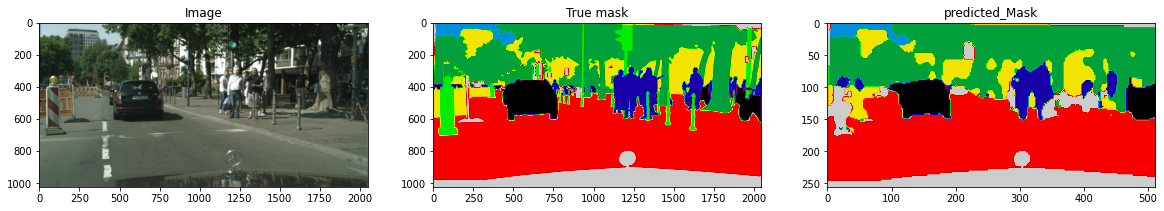

In [ ]:
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=2)

#### Comparison of the model with respect to the two losses.

In [ ]:
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=False)
# Display result
df_result

,model,epoch,training_time,eval_time,freq_weighted_IoU,mean_IoU,void_IoU,flat_IoU,construction_IoU,object_IoU,nature_IoU,sky_IoU,human_IoU,vehicule_IoU
0,mobilenet_segnet_bent,10,10822.000623,206.046655,0.818017,0.700274,0.669688,0.920698,0.792341,0.240373,0.818038,0.839866,0.518774,0.80241
1,mobilenet_segnet_dice,10,9745.670640,80.605151,0.804162,0.660433,0.658285,0.920523,0.774879,0.000000,0.799070,0.861323,0.480863,0.78852
